# **Линейная регрессия**

## **Подготовка для работы в Google Colab или Kaggle**

#### Код для подключения Google Drive в Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Код для получения пути к файлам в Kaggle

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Код для установки библиотек

In [ ]:
%pip install scipy==1.16.3 numpy==2.0.2 pandas==2.2.2 scikit-learn==1.6.1 statsmodels==0.14.6 matplotlib==3.10.0 seaborn==0.13.2

## **Важная информация**

**Для правильного воспроизведения результатов** решения задач:

* Рекомендуется придерживаться имеющего в заданиях кода в исходной последовательности. Для этого при решении задач **восстановите недостающие фрагменты кода, которые отмечены символом** `...` (Ellipsis).

* Если класс, функция или метод предусматривает параметр random_state, всегда указывайте **random_state=RANDOM_STATE**.

* Для всех параметров (кроме random_state) класса, функции или метода **используйте значения по умолчанию, если иное не указано в задании**.

**Если скорость обучения слишком низкая**, рекомендуется следующее:

* В модели или/и GridSearchCV поменяйте значение параметра n_jobs, который отвечает за параллелизм вычислений.

* Воспользуйтесь вычислительными ресурсами Google Colab или Kaggle.

***Использовать GPU не рекомендуется, поскольку результаты обучения некоторых моделей могут отличаться на CPU и GPU.***

После выполнения каждого задания **ответьте на вопросы в тесте.**

**ВНИМАНИЕ:** **После каждого нового запуска ноутбука** перед тем, как приступить к выполнению заданий, проверьте настройку виртуального окружения, выполнив код в ячейке ниже.

In [1]:
# Код для проверки настройки виртуального окружения

import sys
from importlib.metadata import version

required = {
    'python': '3.12.x',
    'scipy': '1.16.3',
    'numpy': '2.0.2',
    'pandas': '2.2.2',
    'scikit-learn': '1.6.1',
    'statsmodels': '0.14.6',
    'matplotlib': '3.10.0',
    'seaborn': '0.13.2'
}

print(f'{"Компонент":<15} | {"Требуется":<12} | {"Установлено":<12} | {"Соответствие"}')
print('-' * 62)

environment_ok = True
for lib, req_ver in required.items():
    try:
        if lib=='python':
            inst_ver = sys.version.split()[0]
            status = '✓' if sys.version_info.major == 3 and sys.version_info.minor == 12 else f'x (требуется {req_ver})'
        else:
            inst_ver = version(lib)
            if inst_ver == req_ver:
                status = '✓'
            else:
                environment_ok = False
                status = f'x (требуется {req_ver})'
    except:
        environment_ok = False
        inst_ver = '-'
        status = 'x (не установлена)'
    print(f'{lib:<15} | {req_ver:<12} | {inst_ver:<12} | {status:<12}')

print('\nРезультат проверки: ', 
      '✓\nВсе версии соответствуют требованиям' 
      if environment_ok else 
      'x\nВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!\n'
      'Для решения проблемы обратитесь к инструкции по настройке виртуального окружения')

Компонент       | Требуется    | Установлено  | Соответствие
--------------------------------------------------------------
python          | 3.12.x       | 3.12.10      | ✓           
scipy           | 1.16.3       | 1.17.0       | x (требуется 1.16.3)
numpy           | 2.0.2        | 2.4.2        | x (требуется 2.0.2)
pandas          | 2.2.2        | 3.0.0        | x (требуется 2.2.2)
scikit-learn    | 1.6.1        | 1.6.1        | ✓           
statsmodels     | 0.14.6       | 0.14.6       | ✓           
matplotlib      | 3.10.0       | 3.10.0       | ✓           
seaborn         | 0.13.2       | 0.13.2       | ✓           

Результат проверки:  x
ВНИМАНИЕ: Версии некоторых компонентов не соответствуют требованиям!
Для решения проблемы обратитесь к инструкции по настройке виртуального окружения


## **Импорт библиотек и вспомогательные функции**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn import datasets

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

In [4]:
RANDOM_STATE = 42

In [5]:
def metrics_report(y_true, y_pred):
    """
    Выводит отчёт с основными метриками качества регрессии.
    Округляет до 4-х знаков после запятой и выводит значения R2 (коэффициент детерминации), RMSE (среднеквадратичная ошибка) и MAPE (средняя абсолютная процентная ошибка) для оценки качества предсказаний.

    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_pred (numpy.ndarray): Предсказанные значения целевой переменной.
    """
    print(f'R2 score: {r2_score(y_true, y_pred):.4f}')
    print(f'RMSE: {mean_squared_error(y_true, y_pred)**0.5:.4f}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}')

In [6]:
def r2_adj_score(y_true, y_pred, k):
    """
    Рассчитывает скорректированный коэффициент детерминации (Adj. R²).
    
    Аргументы:
        y_true (numpy.ndarray): Истинные значения целевой переменной.
        y_pred (numpy.ndarray): Предсказанные значения целевой переменной.
        k (int): Количество факторов.

    Возвращает:
        float: Значение скорректированного коэффициента детерминации.
    """
    return 1 - (1 - r2_score(y_true, y_pred)) * (len(y_true) - 1) / (len(y_true) - k - 1)

## **Практическая часть**

### **Значимость коэффициентов линейной регрессии**

Линейная регрессия позволяет проверять статистические гипотезы, связанные с влиянием независимых переменных (факторов) на зависимую переменную. В частности, гипотезу о значимости коэффициентов регрессии:

* Нулевая гипотеза ($H_0$): Коэффициент при факторе $i$ равен нулю: $\beta_i = 0$ (нет влияния).

* Альтернативная гипотеза ($H_1$): $\beta_i \ne 0$ (фактор значимо влияет на зависимую переменную).

* Метод проверки: t-тест для коэффициентов (если p-value < $\alpha$ (обычно 0.05), отвергаем $H_0$).

### **Коэффициент детерминации ($R^2$)**

**Коэффициент детерминации** ($R^2$) — это статистическая мера, которая показывает, насколько хорошо модель линейной регрессии объясняет вариацию (дисперсию) зависимой переменной. $R^2$ вычисляется по формуле:

$$R^2=1−​\frac{SS_{res}}{​SS_{total}}$$

где $SS_{res}$​ — сумма квадратов остатков (необъяснённая дисперсия), $SS_{total}$​ — общая сумма квадратов (общая дисперсия зависимой переменной).

Чем ближе значение $R^2$ к 1, тем модель лучше объясняет изменения зависимой переменной ($0 \le R^2 \le 1$).

Пример: если $R^2=0.75$, то это означает, что 75% изменений зависимой переменной объясняются моделью, а 25% — случайными факторами.

### ***Задание 1***

Сгенерируйте две переменные:

* `feature` (объясняющий фактор): значение некоторой характеристики товара.

* `cost` (целевая/объясняемая переменная): стоимость товара.

Обучите две модели линейной регрессии на `feature` (предобработка данных не требуется):

* `sk_reg` — модель LinearRegression из библиотеки sklearn (scikit-learn).

* `sm_reg` — модель OLS из библиотеки statsmodels.

Сравните значения коэффициентов обученных моделей `sk_reg` и `sm_reg`, и для модели `sm_reg` проверьте статистическую значимость коэффициентов с помощью метода [summary](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.summary.html).

Рассчитайте $R^2$ для обеих моделей.

**ВНИМАНИЕ:** Перед обучением линейной регрессии в statsmodels (`sm_reg`) необходимо добавить константу к `feature` с помощью метода [add_constant](https://tedboy.github.io/statsmodels_doc/generated/statsmodels.api.add_constant.html).

*Библиотека statsmodels больше ориентирована на статистический анализ и проверку гипотез, тогда как scikit-learn ориентирован на выполнение множества задач в рамках машинного обучения, включая предобработку данных, обучение широкого спектра не классических моделей (в отличие от statsmodels), пайплайны (конвейеры) и многое другое.*

In [7]:
# Сгенерируйте переменные feature и cost
# Переменная rng позволит зафиксировать RANDOM_STATE при генерации случайных чисел в numpy

rng = np.random.RandomState(RANDOM_STATE)

feature = rng.uniform(0, 100, 1000)
cost = feature + rng.normal(3000, 500, 1000)

feature = feature.reshape(-1, 1)

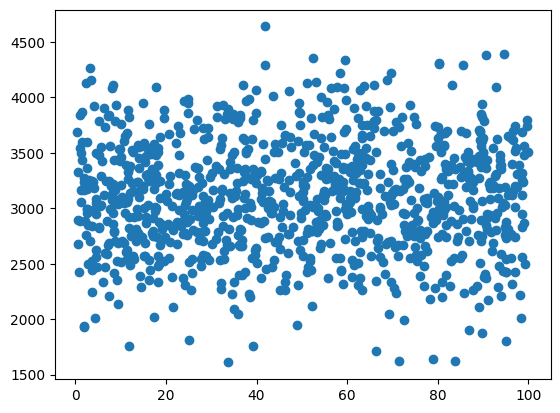

In [8]:
# Постройте точечную диаграмму (scatter plot) cost ~ feature

plt.scatter(
    x=feature,
    y=cost
)
plt.show()

In [ ]:
# Обучите модель sk_reg на всем наборе данных и рассмотрите коэффициенты обученной модели

sk_reg = LinearRegression().fit(feature, cost)

print(sk_reg.coef_, sk_reg.intercept_)


[0.22607418] 3087.3901292465503


In [12]:
# Посчитайте метрики качества модели sk_reg
y_gv = sk_reg.coef_ * feature + sk_reg.intercept_ 

metrics_report(cost, y_gv)

R2 score: 0.0002
RMSE: 493.7023
MAPE: 0.1344


In [13]:
# Обучите модель sm_reg на всем наборе данных и рассмотрите вывод метода summary
# Перед обучением sm_reg необходимо добавить константу к feature с помощью метода add_constant

feature_const = sm.add_constant(feature)
sm_reg = OLS(cost, feature_const).fit()
print(sm_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1784
Date:                Sat, 21 Feb 2026   Prob (F-statistic):              0.673
Time:                        13:27:42   Log-Likelihood:                -7620.9
No. Observations:                1000   AIC:                         1.525e+04
Df Residuals:                     998   BIC:                         1.526e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3087.3901     30.541    101.091      0.0

In [14]:
# Посчитайте метрики качества модели sm_reg
y_sm = sm_reg.predict(feature_const)

metrics_report(cost, y_sm)

R2 score: 0.0002
RMSE: 493.7023
MAPE: 0.1344


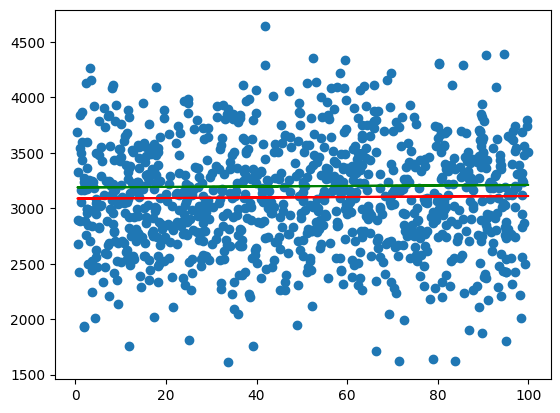

In [18]:
# Постройте точечную диаграмму cost ~ feature и нанесите на нее предсказания одной из моделей

plt.scatter(
    x=feature,
    y=cost
)
plt.plot(feature, y_gv, color='r')
plt.plot(feature, y_sm + 100, color='g')
plt.show()

### **Экзогенность факторов линейной регрессии**

Одно из ключевых предположений линейной регрессии — экзогенность, которая подразумевает, что объясняющие переменные (факторы) не коррелируют с ошибками: 

$$\mathbb{E}[\varepsilon_i|X]=0 \; \forall i$$

где $\mathbb{E}$ — условное математическое ожидание, $\varepsilon_i$ — ошибка для i-го наблюдения, $X$ — матрица всех объясняющих факторов.

**Если предположение об экзогенности нарушается, то оценки регрессии могут стать смещенными и несостоятельными.**

**Примеры нарушения экзогенности:**

* Целевая переменная влияет на фактор. Например, в ситуации, когда моделируется влияние образования на доход, обратная причинность заключается в том, что более высокий доход также позволяет инвестировать в дополнительное образование.

* Фактор и целевая переменная определяются одновременно. Например, в модели спроса и предложения, цена и количество определяются одновременно.

* **Смещение пропущенной переменной (omitted-variable bias)**: существует скрытый фактор $t$, который влияет как на фактор $x$, так и на целевую переменную $f$, но не включен в модель.

Схема смещения пропущенной переменной:


```
                         +-----------------------+
            +----------->| Фактор x              |
            |            +-----------+-----------+
            |                        |            
+-----------+-----------+            |            
| Скрытый фактор t      |            |            
+-----------+-----------+            |            
            |                        V            
            |            +-----------+-----------+
            +----------->| Целевая переменная f  |
                         +-----------------------+
```

В ситуации смещения пропущенной переменной наблюдаемая корреляция между $x$ и $f$ может быть частично или полностью обусловлена влиянием $t$, а не прямой причинно-следственной связью между $x$ и $f$. Если $t$ не включен в модель, его влияние будет поглощено членом ошибки, что приведет к корреляции между фактором $x$ и ошибкой $\varepsilon$. Это нарушает предположение строгой экзогенности и делает оценки регрессии смещенными и несостоятельными.

### **Задание 2**

Сгенерируйте три переменные для моделирования ситуации смещения пропущенной переменной:

* Скрытый ненаблюдаемый фактор `t`.

* Фактор `x`, на который влияет `t`.

* Целевая переменная `f`, на которую влияют факторы `t` и `x`.

Обучите две модели линейной регрессии statsmodels (OLS):

* `reg_biased` — f ~ x (модель предсказывает `f` по значениям `x`).

* `reg_unbiased` — f ~ x + t (модель предсказывает `f` по значениям `x` и `t`).

Выведите summary для `reg_biased` и `reg_unbiased`, сравните коэффициенты при факторах в моделях `reg_biased` и `reg_unbiased` с истинными.

In [19]:
# Сгенерируйте скрытый фактор t
# Сгенерируйте фактор x, на который влияет t
# Сгенерируйте целевую переменную f, на которую влияют факторы t и x
# Истинные коэффициенты при факторах:
#   x: 2
#   t: -4
# Переменная rng позволит зафиксировать RANDOM_STATE при генерации случайных чисел в numpy

rng = np.random.RandomState(RANDOM_STATE)

t = rng.normal(0, 1, 1000)
x = 0.5 * t + rng.normal(0, 0.5, 1000)
f = 2 * x - 4 * t + rng.normal(0, 1, 1000)

In [20]:
# Обучите модель f ~ x и выведите summary
# Перед обучением reg_biased необходимо добавить константу с помощью метода add_constant

X_biased = sm.add_constant(x)
reg_biased = OLS(f, X_biased).fit()
reg_biased.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     190.8
Date:                Sat, 21 Feb 2026   Prob (F-statistic):           7.79e-40
Time:                        13:45:52   Log-Likelihood:                -2515.1
No. Observations:                1000   AIC:                             5034.
Df Residuals:                     998   BIC:                             5044.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1049      0.095      1.105      0.270      -0.081       0.291
x1            -1.9121      0.138    -13.812      0.000      -2.184      -1.640
==============================================================================
Omnibus:                        0.848   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.655   Jarque-Bera (JB):                0.931
Skew:                          -0.050   Prob(JB):                        0.628
Kurtosis:                       2.888   Cond. No.                         1.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# Обучите модель f ~ x + t и выведите summary
# Перед обучением reg_unbiased необходимо добавить константу с помощью метода add_constant

X = np.column_stack((x, t))
X_unbiased = sm.add_constant(X)
reg_unbiased = OLS(f, X_unbiased).fit()
reg_unbiased.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     5009.
Date:                Sat, 21 Feb 2026   Prob (F-statistic):               0.00
Time:                        13:50:45   Log-Likelihood:                -1401.5
No. Observations:                1000   AIC:                             2809.
Df Residuals:                     997   BIC:                             2824.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.031      0.197      0.844      -0.055       0.067
x1             1.9796      0.062     31.682      0.000       1.857       2.102
x2            -3.9680      0.044    -90.830      0.000      -4.054      -3.882
==============================================================================
Omnibus:                        1.860   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.394   Jarque-Bera (JB):                1.756
Skew:                           0.060   Prob(JB):                        0.416
Kurtosis:                       3.167   Cond. No.                         2.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
reg_biased.params
# reg_unbiased.params

array([ 0.10487838, -1.91207117])

In [29]:
# Сравните коэффициенты при факторах в моделях reg_biased и reg_unbiased с истинными

print('Истинный коэффициент при x: 2')
print('Истинный коэффициент при t: - 4')

print(f'Смещенный коэффициент при x (f ~ x): {reg_biased.params[1]:.2f}')

print(f'Несмещенный коэффициент при x (f ~ x + t): {reg_unbiased.params[1]:.2f}')
print(f'Несмещенный коэффициент при t (f ~ x + t) {reg_unbiased.params[2]:.2f}')

Истинный коэффициент при x: 2
Истинный коэффициент при t: - 4
Смещенный коэффициент при x (f ~ x): -1.91
Несмещенный коэффициент при x (f ~ x + t): 1.98
Несмещенный коэффициент при t (f ~ x + t) -3.97


### **Предобработка данных**

**Предобработка данных** — это важнейший аспект машинного обучения, который напрямую влияет на качество, точность и производительность моделей ML. Данные в сыром виде часто бывают неполными или плохо структурированными, и без их предварительной подготовки построение эффективных моделей практически невозможно.

**Основные этапы предобработки данных:**

1. **Сбор и интеграция данных.** Загрузка данных из одного или нескольких источников и объединение их в один датасет (или несколько датасетов).

2. **Первичный анализ данных.** Подсчет статистических характеристик датасета, построение графиков и оценка корреляционных зависимостей между переменными.

3. **Очистка данных.** Удаление дубликатов и исправление явных ошибок (опечатки, отрицательный возраст).

4. **Обработка пропусков.** 

* Удаление строк с пропусками.

* Удаление столбцов с пропусками.

* Заполнение описательными характеристиками (средним/модой/медианой).

* Заполнение прогнозом (KNN, Regression, MICE).

5. **Обработка категориальных признаков.**

* One-Hot Encoding.

* Ordinal/Label Encoding.

6. **Разделение данных.** Разделение данных на обучающую, валидационную и тестовую выборки.

7. **Масштабирование числовых (количественных) признаков.**

* StandardScaler.

* MinMaxScaler.

*Это лишь основные этапы предобработки данных. На практике количество существующих методов обработки данных намного больше, а структура и порядок этапов **зависит от решаемой задачи***.

**Необходимым условием правильного выполнения последующих заданий является правильная предобработка данных.**

Процедура предобработки указывается в заданиях курса и, как правило, включает в себя считывание данных, выделение целевой переменной, обработку категориальных признаков с помощью One-Hot кодирования, разделение данных на обучающую (train) и тестовую (test) выборки, а также масштабирование числовых признаков с помощью стандартизации (Standard Scaler).

### **Датасет *Housing Prices Dataset***

**Для решения заданий 3 — 9 рассмотрим датасет [Housing Prices Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset).**

Набор данных предназначен для решения задачи регрессии — прогнозирования цены дома на основе его характеристик.

Целевая переменная — price (цена дома).

Датасет содержит признаки:

* Площадь (area).

* Количество комнат (bedrooms, bathrooms).

* Количество этажей (stories).

* Количество парковочных мест (parking).

* Близость к главной дороге, категориальный (mainroad).

* Уровень меблировки, категориальный (furnishingstatus).

* Наличие гостевой комнаты и подвала, бинарные (guestroom, basement).

* Наличие водонагревателя и кондиционера, бинарные (hotwaterheating, airconditioning).

* Находится ли дом в предпочтительном районе (prefarea).

### ***Задание 3***

Выполните предобработку данных:

1. **read_csv**: считайте набор данных стоимости жилья и выделите объясняемый фактор в отдельную переменную.

2. **OneHotEncoder:** закодируйте категориальные переменные значениями 0 и 1.

3. **train_test_split:** разделите датасет на обучающую (60%) и тестовую (40%).

4. **StandardScaler:** масштабируйте количественные переменные.

Используя метод describe, рассмотрите статистические характеристики исходного датасета и подготовленных выборок.

In [ ]:
# Считайте набор данных

df_housing = pd.read_csv('house_prices.csv')
df_housing

#### **Как определить тип признака с помощью метода [info](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html)**

Метод info (pandas) выводит тип данных (dtype) каждого столбца, но не классифицирует их явно на количественные и категориальные. Однако по dtype можно сделать предположение:

* int, float — как правило, количественные, но могут быть и категориальными (например, бинарный признак 0/1 или порядковый код категории).

* object, string, bool, category — как правило, категориальные.

**ВНИМАНИЕ:** В используемом датасете int64 — количественные, object —категориальные.

In [ ]:
# Используя метод info, определите типы признаков

df_housing.info()

In [ ]:
# Создайте списки количественных и категориальных переменных (не включая целевую переменную)

housing_num_feat = ...
housing_cat_feat = ...

#### **Что показывает метод [describe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html)**

* **Для числовых (количественных) признаков**

    * count — количество не пропущенных значений.

    * mean — среднее арифметическое.

    * std — стандартное отклонение.

    * min — минимальное значение.

    * 25% — первый квартиль (25-й процентиль).

    * 50% — медиана (50-й процентиль).

    * 75% — третий квартиль (75-й процентиль).

    * max — максимальное значение.

* **Для категориальных признаков**

    * count — количество не пропущенных значений.

    * unique — число уникальных значений.

    * top — самое часто встречающееся значение.
    
    * freq — частота значения top.

In [ ]:
# Посчитайте статистические характеристики количественных признаков

df_housing[housing_num_feat].describe()

In [ ]:
# Посчитайте статистические характеристики категориальных признаков

df_housing[housing_cat_feat].describe()

In [ ]:
# Выделите объясняемый фактор в отдельную переменную

X_housing, y_housing = ...

#### **Как использовать [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)**

OneHotEncoder в sklearn преобразует категориальные признаки в бинарные (one-hot) столбцы. 

Параметры:

* drop='first' — удаляет первый столбец для каждого признака (для избежания мультиколлинеарности).

* sparse=False — возвращает результат в виде массива numpy вместо разреженной матрицы.

*Более продвинутые способы использования — в ColumnTransformer и Pipeline, будут рассмотрены в следующих домашних заданиях.*

In [ ]:
# Закодируйте категориальные признаки числами 0 и 1 с помощью OneHotEncoder

housing_encoder = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')

X_housing_encoded = ...
X_housing = X_housing.join(X_housing_encoded)
X_housing = X_housing.drop(columns=...) # Удаляем исходные столбцы после One-Hot кодирования

#### **Как использовать [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**

Функция train_test_split позволяет разделить данные на две выборки: обучающую и тестовую.

Параметры:

* test_size — определяет долю данных, которая пойдет в тестовую выборку.

* **random_state** — фиксирует случайное разделение для воспроизводимости результатов.

* shuffle (по умолчанию True) — перемешивает данные перед разделением. Если False, данные делятся последовательно.

* stratify (по умолчанию None) — обеспечивает стратификацию (передаётся массив меток).

**Стратификация** — это способ разделения данных так, чтобы в обучающей и тестовой выборках сохранялось примерно такое же соотношение классов, как в исходных данных.

In [ ]:
# С помощью train_test_split разделите датасет на обучающую (60%) и тестовую (40%) выборки с перемешиванием, без стратификации
# Не забудьте зафиксировать RANDOM_STATE

X_housing_train, X_housing_test, y_housing_train, y_housing_test = ...

#### **Как использовать [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) с обучающей и тестовой выборками для масштабирования количественных признаков**

**Основные принципы:**

* Обучайте (fit) скейлер только на обучающих данных.

* Применяйте преобразование (transform) к обучающим и тестовым данным.

* Не обучайте scaler на полной выборке (до разделения), это приведет к ["утечке информации" (data leakage)](https://scikit-learn.org/stable/common_pitfalls.html#data-leakage).

* [Используйте одинаковое преобразование для train и test](https://scikit-learn.org/stable/common_pitfalls.html#inconsistent-preprocessing).

* В рамках домашних заданий применяйте скейлер **только на количественных признаках**.

*Более продвинутые способы использования — в ColumnTransformer и Pipeline, будут рассмотрены в следующих домашних заданиях.*

In [ ]:
# Масштабируйте количественные признаки с помощью StandardScaler
#   train -> fit_transform
#   test -> transform

housing_scaler = StandardScaler().set_output(transform='pandas')

X_housing_train_scaled = X_housing_train.copy()
X_housing_train_scaled[housing_num_feat] = ... # fit_transform

X_housing_test_scaled = X_housing_test.copy()
X_housing_test_scaled[housing_num_feat] = ... # transform

In [ ]:
# Посчитайте статистические характеристики признаков в обучающей выборке (describe)

...

In [ ]:
# Посчитайте статистические характеристики признаков в тестовой выборке (describe)

...

### **Скорректированный коэффициент детерминации ($Adj.\;R^2$)**

**Скорректированный коэффициент детерминации** ($Adj.\;R^2$) — это модификация $R^2$, которая учитывает количество факторов в модели и штрафует за добавление незначимых переменных. $Adj.\;R^2$ рассчитывается по формуле:

$$Adj.\;R^2=1−\frac{(1-R^2)(n-1)}{n-k-1}$$

где $n$ — число наблюдений, $k$ — число факторов в модели.

Если при добавлении новых переменных $R^2$ растет (не уменьшается), то $Adj.\;R^2$ может уменьшиться, если новый фактор не улучшает объясняющую способность модели.

При сравнении двух моделей с одинаковым числом признаков можно использовать как $R^2$, так и $Adj.\;R^2$. Если число признаков у двух моделей отличается, то следует использовать $Adj.\;R^2$, поскольку $R^2$ не учитывает количество признаков.

### ***Задание 4***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **после масштабирования** из задания 3: `X_housing_train_scaled`.

На выборке `X_housing_train_scaled` обучите модель линейной регрессии statsmodels `reg_housing`, и с помощью анализа summary модели `reg_housing` (или с помощью t-теста) определите незначимые **количественные** факторы на уровне значимости 5%.

*Использовать t-тест для проверки значимости **категориальной** переменной с $k > 2$ уровней нельзя. Категориальная переменная с $k > 2$ уровнями требует проверки влияния всех уровней одновременно (например, с помощью F-теста), а не попарно. В то же время **категориальные бинарные** ($k = 2$) переменные могут быть проверены на значимость с помощью t-теста.*

Далее убедимся, что при добавлении новых незначимых признаков в линейную регрессию:

* Коэффициент детерминации $R^2$ растет (не уменьшается).

* Скорректированный коэффициент детерминации $Adj.\;R^2$ уменьшается (не увеличивается).

Добавьте в выборку `X_housing_train_scaled` 10 случайных независимых факторов и сравните, насколько изменились $R^2$ и $Adj.\;R^2$.

In [ ]:
# Обучите регрессию reg_housing на обучающей выборке
# Перед обучением регрессии statsmodels необходимо добавить константу с помощью метода add_constant

X_housing_train_scaled_const = ...
reg_housing = ...

In [ ]:
# Определите незначимые количественные признаки на уровне значимости 5%

...

In [ ]:
# Сгенерируйте случайные факторы и добавьте их в обучающую выборку
# Не забудьте зафиксировать RANDOM_STATE

rng = np.random.RandomState(RANDOM_STATE)

noise = pd.DataFrame(
        rng.normal(0, 1, size=(X_housing_train_scaled.shape[0], 10)),
        index=X_housing_train_scaled.index
)

X_housing_train_scaled_noise = X_housing_train_scaled.join(noise)

In [ ]:
# Обучите регрессию reg_housing на обучающей выборке со случайными факторами
# Перед обучением регрессии statsmodels необходимо добавить константу с помощью метода add_constant

X_housing_train_scaled_noise_const = ...
reg_housing_noise = ...

In [ ]:
# Сравните, насколько изменились R² и Adj. R² после добавления случайных факторов

...

### ***Задание 5***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **после масштабирования** из задания 3: `X_housing_train_scaled`, `y_housing_train`.

* Тестовую выборку **после масштабирования** из задания 3: `X_housing_test_scaled`, `y_housing_test`.

Обучите модель линейной регрессии sklearn с L2-регуляризацией (Ridge) `ridge_housing` с оптимальными гиперпараметрами, подобрав их с помощью GridSearchCV.

Используя абсолютные коэффициенты (по модулю) обученной модели `ridge_housing` определите наиболее влиятельный **количественный** признак.

Обучите вторую Ridge модель `ridge_housing_area` с оптимальными гиперпараметрами (оптимальные гиперпараметры подберите заново, с помощью GridSearchCV) только на одном параметре — площади (area).

Сравните $Adj.\;R^2$ обученных моделей, используя функцию r2_adj_score.

#### **Как использовать [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) для подбора оптимальных параметров модели**

GridSearchCV выполняет перебор всех возможных комбинаций параметров из заданной сетки с кросс-валидацией и обучает модель для каждой такой комбинации. По результатам перебора GridSearchCV выбирает модель, которая оказалась наилучшей с точки зрения заданной метрики обучения (по умолчанию для линейной регрессии — Negative Root Mean Squared Error).

**ВНИМАНИЕ:** Оптимальными гиперпараметрами обучения будем считать те, которые привели к обучению наилучшей модели при переборе с помощью GridSearchCV.

In [ ]:
# Подберите оптимальные гиперпараметры обучения ridge_housing с помощью GridSearchCV на всех факторах

# Определяем сетку гиперпараметров обучения и количество фолдов
params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0], 
    'solver': ['saga', 'svd', 'lsqr']
}
cv = 5

# Создаем объект GridSearchCV с указанием модели, сетки параметров и количеством фолдов (5)
cv_ridge_housing = GridSearchCV(
    estimator=Ridge(random_state=RANDOM_STATE),
    param_grid=params,
    cv=cv
)

# Запускаем перебор гиперпараметров и обучение моделей
cv_ridge_housing.fit(...)

# Посчитаем метрику обучения и оптимальные гиперпараметры лучшей модели
print(f'Best score is {cv_ridge_housing.best_score_}, best parameters are {cv_ridge_housing.best_params_}')

In [ ]:
# Обучите ridge_housing с оптимальными параметрами на всех факторах
# Не забудьте зафиксировать RANDOM_STATE

ridge_housing = Ridge(**cv_ridge_housing.best_params_, random_state=RANDOM_STATE).fit(...)

In [ ]:
# Используя коэффициенты ridge_housing, определите наиболее влиятельный количественный признак

housing_coefs = pd.DataFrame(
    {'coef': ...},
    index=ridge_housing.feature_names_in_
)
housing_coefs['significance'] = ....abs()
housing_coefs.sort_values(...)

In [ ]:
# Посчитайте Adj. R² для ridge_housing на тестовой выборке

k = len(ridge_housing.feature_names_in_) # Количество факторов
print(r2_adj_score(...))

In [ ]:
# Обучите ridge_housing_area с оптимальными гиперпараметрами только на одном параметре — площади (area)
# Оптимальные гиперпараметры подберите заново, с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0], 
    'solver': ['saga', 'svd', 'lsqr']
}
cv = 5

cv_ridge_housing_area = ...

ridge_housing_area = ...

In [ ]:
# Посчитайте Adj. R² для ridge_housing_area на тестовой выборке

k = len(ridge_housing_area.feature_names_in_) # Количество факторов
...

### ***Задание 6***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **до и после масштабирования** из задания 3: `X_housing_train`, `X_housing_train_scaled`.

* Обученную модель `ridge_housing` из задания 5.

Используя `ridge_housing`, определите, как изменится стоимость дома при увеличении количества этажей (stories) на два при прочих равных условиях. Для этого необходимо:

1. **Теоретически** рассчитать изменение на основе коэффициента регрессии.

2. **Эмпирически** проверить результат, искусственно увеличив количество этажей в **обучающей** выборке, предсказав новую стоимость и рассчитав изменение.

**ВНИМАНИЕ:** При теоретическом расчёте изменения **учитывайте масштабирование** количественных признаков. Подсказка: подумайте, как можно использовать scaler.var_.

In [ ]:
# Подготовьте выборку с увеличенным количеством этажей

X_housing_plus2_train = ...
X_housing_plus2_train_scaled = ...

In [ ]:
# Теоретически рассчитайте изменение на основе коэффициента регрессии

...

In [ ]:
# Эмпирически проверьте результат, предсказав новую стоимость и рассчитав изменение

...

### ***Задание 7***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **до и после масштабирования** из задания 3: `X_housing_train`, `X_housing_train_scaled`.

* Тестовую выборку **до и после масштабирования** из задания 3: `X_housing_test`, `X_housing_test_scaled`, `y_housing_test`.

* Обученную модель `ridge_housing` из задания 3.

Проверим предположение о том, что ухудшение репрезентативности выборки влияет на качество модели. Для этого рассмотрим три выборки:

1. **Обучающая** — полная обучающая выборка, которая использовалась ранее: `X_housing_train`, `X_housing_train_scaled`.

2. **Ограниченная обучающая** — обучающая выборка, включающая в себя только данные о домах, в которых площадь не более 3200 (area <= 3200): `X_housing_limited_train`, `X_housing_limited_train_scaled`.

3. **Тестовая** — полная тестовая выборка, которая использовалась ранее: `X_housing_test`, `X_housing_test_scaled`.

Подготовьте ограниченную обучающую выборку `X_housing_limited_train_scaled` (с масштабированием) и обучите на ней модель Ridge `ridge_housing_limited`, подобрав оптимальные гиперпараметры обучения с помощью GridSearchCV.

Сравните $R^2$ для моделей `ridge_housing` и `ridge_housing_limited` на тестовой выборке. Тестовую выборку необходимо правильно масштабировать (см. ниже).

**ВНИМАНИЕ:** Для масштабирования ограниченной обучающей выборки используйте новый StandardScaler (`housing_limited_scaler`). Учтите, что тестовую выборку необходимо масштабировать тем же скейлером, что использовался при обучении. Это означает, что при сравнении двух моделей, обученных на выборках с разными скейлерами, необходимо использовать тестовые выборки, преобразованные соответствующими скейлерами:

* `ridge_housing` -> `X_housing_test_scaled` (`housing_scaler`).

* `ridge_housing_limited` -> `X_housing_limited_test_scaled` (`housing_limited_scaler`).

In [ ]:
# Подготовьте ограниченную обучающую выборку из исходной (без масштабирования)

X_housing_limited_train = X_housing_train[X_housing_train['area'] <= 3200]
y_housing_limited_train = ...

In [ ]:
# Подготовьте ограниченную обучающую выборку с масштабированием
# ВНИМАНИЕ: Используйте новый StandardScaler (housing_limited_scaler)

housing_limited_scaler = StandardScaler().set_output(transform='pandas')

X_housing_limited_train_scaled[housing_num_feat] = ...

In [ ]:
# Подготовьте тестовую выборку с масштабированием (housing_limited_scaler)

X_housing_limited_test_scaled[housing_num_feat] = ...

In [ ]:
# Обучите ridge_housing_limited на ограниченной обучающей выборке
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {
    'alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0], 
    'solver': ['saga', 'svd', 'lsqr']
}
cv = 5

cv_ridge_housing_limited = ...
ridge_housing_limited = ...

In [ ]:
# Сравните R² для моделей ridge_housing и ridge_housing_limited на тестовых выборках
# Используйте тестовые выборки, преобразованные теми же скейлерами, что и обучающая выборка

...

### **Мультиколлинеарность и VIF**

Еще одно из ключевых допущений линейной регрессии — отсутствие мультиколлинеарности между переменными. 

**Мультиколлинеарность** — это явление, при котором две или более независимые переменные в модели линейной регрессии сильно коррелируют друг с другом. Проще говоря, если изменение одной переменной тесно связано с изменением другой, то они являются мультиколлинеарными.

**Последствия мультиколлинеарности:**

* Оценки коэффициентов регрессии становятся очень чувствительными к небольшим изменениям в данных.

* Усложняется оценка индивидуального влияния каждого фактора на зависимую переменную, так как их эффекты смешиваются.

**Методы обнаружения мультиколлинеарности:**

* Проверка парных корреляций. Если есть очень высокие значения (например, больше 0.8), это может указывать на наличие мультиколлинеарности.

* Variance Inflation Factor (VIF). VIF оценивает, насколько дисперсия коэффициента регрессии увеличивается из-за мультиколлинеарности.

Для каждого фактора $X_{j}$​ VIF вычисляется по формуле:

$$\mathrm{VIF}_{j}=\frac{1}{1-R^2_{j}}$$

где $R^2_{j}$​ — коэффициент детерминации модели, в которой строится регрессия $X_{j}$​ на все остальные факторы.

**Интерпретация VIF:**

* VIF = 1 — фактор не коррелирует с остальными.

* 1 < VIF < 5 — фактор умеренно (допустимо) коррелирует с остальными.

* VIF ≥ 5 — наличие мультиколлинеарности.

**Методы устранения мультиколлинеарности:**

* Удаление одной из коррелирующих переменных. Если две переменные мультиколлинеарны, можно удалить одну из них, оставив ту, которая более теоретически обоснована или имеет большее значение.

* Объединение переменных. Создание новой переменной, которая является комбинацией мультиколлинеарных переменных.

* Использование моделей с регуляризацией. Модели Ridge и LASSO разработаны для работы с мультиколлинеарностью путем добавления штрафа, который уменьшает влияние коррелированных переменных.

### ***Задание 8***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку **после масштабирования** из задания 3: `X_housing_train_scaled`, `y_housing_train`.

* Модель линейной регрессии statsmodels из задания 4: `reg_housing`.

Добавьте в обучающую выборку новый фактор something, линейно зависящий от фактора stories (обучающая выборка с фактором something — `X_housing_extended_train_scaled`).

Постройте корреляционную матрицу для `X_housing_extended_train_scaled` (метод [corr](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)).

Рассчитайте VIF для всех признаков в `X_housing_extended_train_scaled` (функция [variance_inflation_factor](https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)) и определите наличие мультиколлинеарности.

Обучите модель линейной регрессии statsmodels (OLS) `reg_housing_extended` на обучающей выборке `X_housing_extended_train_scaled` (после добавления something).

Сравните summary моделей `reg_housing` и `reg_housing_extended`.

In [ ]:
# Добавьте в обучающую выборку новый фактор something, линейно зависящий от фактора stories
# Не забудьте зафиксировать RANDOM_STATE

rng = np.random.RandomState(RANDOM_STATE)

X_housing_extended_train_scaled = X_housing_train_scaled.copy()
X_housing_extended_train_scaled['something'] = X_housing_extended_train_scaled['stories'] * 2 + 0.5 + rng.normal(0, 0.5, X_housing_extended_train_scaled.shape[0])

# Стандартизируем новый фактор something (масштабируем)
X_housing_extended_train_scaled['something'] = StandardScaler().fit_transform(X_housing_extended_train_scaled[['something']])

In [ ]:
# Постройте корреляционную матрицу для X_housing_extended_train_scaled

plt.figure(figsize=(12, 12))
sns.heatmap(..., annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# Рассчитайте VIF в X_housing_extended_train_scaled для всех признаков и определите наличие мультиколлинеарности

vif_data = pd.DataFrame()
vif_data['feature'] = X_housing_extended_train_scaled.columns
vif_data['VIF'] = [variance_inflation_factor(...) 
               for i in range(...)]
vif_data

In [ ]:
# Обучите модель reg_housing_extended

X_housing_extended_train_scaled_const = ...
reg_housing_extended = ...

In [ ]:
# Сравните summary моделей reg_housing и reg_housing_extended

...

### **Гетероскедастичность и тест Уайта**

**Гетероскедастичность** — это нарушение одной из ключевых предпосылок классической линейной регрессии, которое заключается в том, что дисперсия (разброс) остатков модели не является постоянной для всех наблюдений.

**Последствия гетероскедастичности:**

* Неэффективность МНК-оценок — оценки, полученные с помощью метода наименьших квадратов (МНК), не являются наиболее точными.

* Смещённость и несостоятельность ковариационной матрицы МНК-оценок. Это приводит к тому, что статистические выводы о качестве полученных оценок (t-тесты, F-тест и доверительные интервалы) могут быть неадекватными.

**Выявление гетероскедастичности:**

* Графики остатков регрессии. В первом приближении наличие гетероскедастичности можно выявить на графиках остатков регрессии по некоторым переменным, по оцененной зависимой переменной или по номеру наблюдения: разброс точек может меняться в зависимости от значения этих переменных. 

* Статистические тесты Уайта, Голдфелда-Квандта, Бройша-Пагана, Парка, Глейзера, Спирмена. 

**Тест Уайта** — это один из наиболее часто применяемых статистических тестов для обнаружения гетероскедастичности, преимущество которого заключается в том, что он не требует заранее предполагать, от чего именно зависит дисперсия ошибки. Суть этого теста заключается в проверке, существует ли статистически значимая связь между квадратами остатков исходной модели и факторами, а также их квадратами и попарными произведениями.

**Тест Уайта:**

1. Оценивается исходная регрессия и вычисляются её остатки ($e$).

2. Строится вспомогательная регрессия квадратов остатков ($e^2$) на исходные признаки, их квадраты и попарные произведения.

3. Проверяется гипотеза:

    * $H_0$: гетероскедастичности нет (гомоскедастичность, дисперсия ошибок постоянна).
    
    * $H_1$: гетероскедастичность присутствует.

### ***Задание 9***

**ВНИМАНИЕ:** Для решения этого задания используйте:

* Обучающую выборку из задания 3: `X_housing_train_scaled`, `y_housing_train`.

* Обученную модель statsmodels из задания 4: `reg_housing`.

Посчитайте остатки регрессии `reg_housing` и постройте графики их распределения.

Проверьте наличие гетероскедастичности в данных модели `reg_housing` с помощью теста Уайта на уровне значимости 5% ([het_white](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_white.html)).

In [ ]:
# Посчитайте остатки регрессии reg_housing

reg_housing_res = ...

In [ ]:
# Постройте график распределения остатков регрессии

plt.xlabel('Остатки')
plt.ylabel('Частота')
reg_housing_res.hist(bins=50)

In [ ]:
# Постройте график распределения остатков reg_housing в зависимости от предсказанных значений (fitted values)

plt.figure(figsize=(6, 4))
plt.xlabel('Предсказания объясняемого фактора')
plt.ylabel('Отстатки')
plt.scatter(
    x=..., 
    y=reg_housing_res
)
plt.show()

In [ ]:
# Выполните тест Уайта

housing_white_test = het_white(...)

housing_white_test_result = pd.DataFrame(
    np.round(housing_white_test, 6), 
    index=['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value'], 
    columns=['Value']
)

### **Датасет *Diabetes dataset***

**Для решения задания 10 рассмотрим датасет [Diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).**

Этот маленький датасет (442 наблюдения) предназначен для решения задачи регрессии. Его основная цель — предсказать прогрессирование диабета у пациента через год на основе диагностических показателей. 

Целевая переменная — числовой показатель, отражающий степень прогрессирования диабета.

Набор содержит 10 числовых признаков, которые были предварительно стандартизированы: 

* age — возраст.

* sex — пол.

* bmi — индекс массы тела (BMI).

* bp — среднее артериальное давление.

* s1 (tc) — общий холестерин сыворотки крови (Total Serum Cholesterol).

* s2 (ldl) — липопротеины низкой плотности (Low-Density Lipoproteins, "плохой" холестерин).

* s3 (hdl) — липопротеины высокой плотности (High-Density Lipoproteins, "хороший" холестерин).

* s4 (tch) — общий холестерин / HDL.

* s5 (ltg) — логарифм уровня триглицеридов в сыворотке крови (Log of Serum Triglycerides Level).

* s6 (glu) — уровень глюкозы в крови.

### **Методы регуляризации: Ridge, LASSO**

При обучении линейных регрессионных моделей часто возникают две проблемы: переобучение (модель слишком хорошо подстраивается под обучающие данные и плохо работает на новых) и мультиколлинеарность (сильная корреляция между факторами). 

**Регуляризация** — это метод, который позволяет бороться с этими проблемами путем добавления штрафа за сложность модели к ее функции потерь. Суть метода заключается в том, чтобы заставить модель не только минимизировать ошибку предсказания, но и удерживать коэффициенты при факторах небольшими. 

Рассмотрим два ключевых метода регуляризации: LASSO (L1-регуляризация) и Ridge (L2-регуляризация).

**LASSO (Least Absolute Shrinkage and Selection Operator)**

Функция потерь LASSO:

$$J(\theta)=\text{MSE}(\theta) + \alpha \sum_{i=1}^{k}|\theta_i|$$

где $\text{MSE}(\theta)$ — среднеквадратичная ошибка, $\theta_i$ — коэффициент при $i$-том факторе модели, $\alpha$ (альфа) — гиперпараметр, контролирующий силу штрафа.

LASSO-регрессия способна полностью обнулять коэффициенты при наименее важных факторах. Таким образом, LASSO не только уменьшает сложность модели, но и выполняет отбор наиболее важных признаков.

Если в данных есть группа сильно скоррелированных факторов, LASSO имеет тенденцию произвольно выбирать один из них, а остальные обнулять.

**Ridge-регрессия**

Функция потерь Ridge:

$$J(\theta)=\text{MSE}(\theta) + \alpha \sum_{i=1}^{k}\theta_i^2$$
    
Ridge-регрессия уменьшает абсолютные значения коэффициентов, что делает модель более устойчивой, особенно при наличии мультиколлинеарности. Важная особенность L2-штрафа в том, что он лишь уменьшает коэффициенты, стремясь к нулю, но никогда не обнуляет их полностью. Таким образом, в модели остаются все факторы.

### ***Задание 10***

Выполните предобработку датасета (см. код задания) и обучите три линейных регрессии sklearn:

* `reg_diab` — регрессия без регуляризации (LinearRegression).

* `lasso_diab` — регрессия с L1-регуляризацией (LASSO). Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV.

* `ridge_diab` — регрессия с L2-регуляризацией (Ridge). Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV.

Для каждой из моделей выведите metrics_report на тестовой выборке и определите признаки, которые были исключены из регрессии L1-регуляризацией (LASSO).

In [ ]:
# Загрузите набор данных с помощью sklearn.datasets и выделите объясняемый фактор в отдельную переменную

df_diab = datasets.load_diabetes()
X_diab = pd.DataFrame(df_diab.data)
X_diab.columns = df_diab.feature_names
y_diab = df_diab.target

In [ ]:
# Нормализуйте значение целевой переменной

y_diab = (y_diab - y_diab.min()) / (y_diab.max() - y_diab.min())

In [ ]:
# Разделите датасет на обучающую (75%) и тестовую (25%) выборки (с перемешиванием, без стратификации)
# Не забудьте зафиксировать RANDOM_STATE

X_diab_train, X_diab_test, y_diab_train, y_diab_test = ...

In [ ]:
# Обучите линейную регрессию без регуляризации reg_diab и выведите metrics_report на тестовой выборке

reg_diab = ...
metrics_report(...)

In [ ]:
# Обучите модель lasso_diab (LASSO) и выведите metrics_report на тестовой выборке
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
cv = 5

cv_lasso_diab = ...
lasso_diab = ...

metrics_report(...)

In [ ]:
# Обучите модель ridge_diab (Ridge) и выведите metrics_report на тестовой выборке
# Оптимальные гиперпараметры обучения подберите с помощью GridSearchCV
# Не забудьте зафиксировать RANDOM_STATE

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}
cv = 5

cv_ridge_diab = ...
ridge_diab = ...

metrics_report(...)

In [ ]:
# Рассмотрите коэффициенты моделей

diab_coefs = pd.DataFrame({
    'reg_diab coef': ...,
    'lasso_diab coef': ...,
    'ridge_diab coef': ...
}, index=X_diab.columns
)